In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)

In [3]:
items = pd.read_csv('../data/items.csv')
shops = pd.read_csv('../data/shops.csv')
cats = pd.read_csv('../data/item_categories.csv')
train = pd.read_csv('../data/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('../data/test.csv').set_index('ID')

2
12
2935837


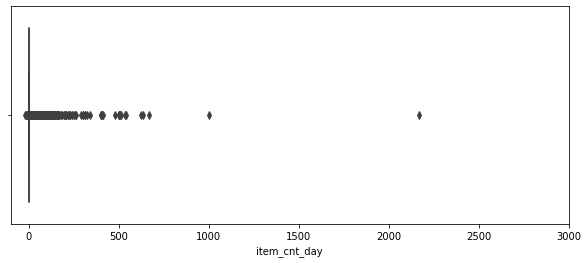

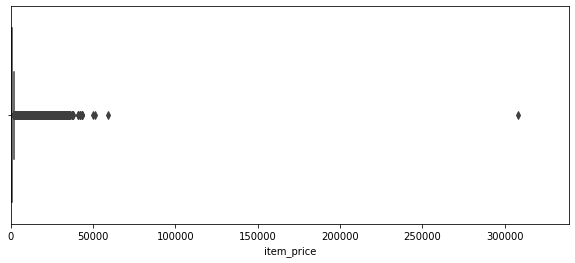

In [4]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

print(len(train[train.item_cnt_day>999]))
print(len(train[train.item_cnt_day>500]))
print(len(train[train.item_cnt_day<501]))

train = train[train.item_price<100000]
train = train[train.item_cnt_day<1000]

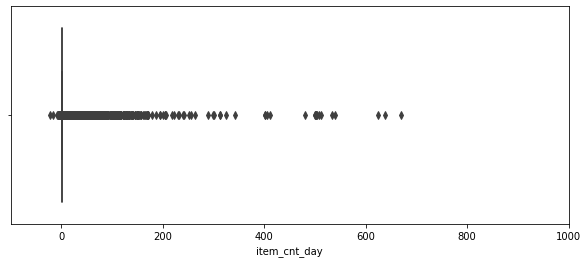

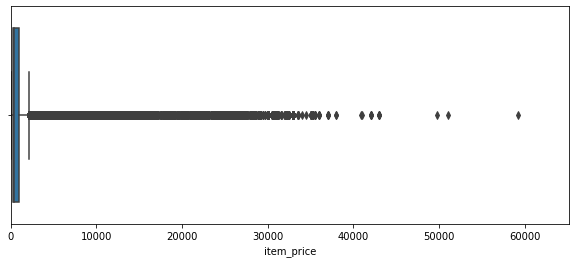

In [5]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 1000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [6]:
train = train[train.item_price > 0].reset_index(drop=True)
train[train.item_cnt_day <= 0].item_cnt_day.unique()
train.loc[train.item_cnt_day < 1, 'item_cnt_day'] = 0

In [7]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 11, 'shop_id'] = 10
test.loc[test.shop_id == 11, 'shop_id'] = 10

train.loc[train.shop_id == 40, 'shop_id'] = 39
test.loc[test.shop_id == 40, 'shop_id'] = 39

In [8]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['category'] = shops['shop_name'].str.split(' ').map(lambda x:x[1]).astype(str)

shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

category = ['Орджоникидзе,', 'ТЦ', 'ТРК', 'ТРЦ','ул.', 'Магазин', 'ТК', 'склад']
shops.category = shops.category.apply(lambda x: x if (x in category) else 'etc')
shops.category.unique()

array(['Орджоникидзе,', 'ТЦ', 'ТРК', 'ТРЦ', 'etc', 'ул.', 'Магазин', 'ТК',
       'склад'], dtype=object)

In [9]:
shops.groupby(['category']).sum()

,shop_id
category,
etc,68
Магазин,22
"Орджоникидзе,",57
ТК,184
ТРК,140
ТРЦ,340
ТЦ,883
склад,55
ул.,21


In [10]:
category = ['ТЦ', 'ТРК', 'ТРЦ', 'ТК']
shops.category = shops.category.apply(lambda x: x if (x in category) else 'etc')
print('Category Distribution', shops.groupby(['category']).sum())

Category Distribution           shop_id
category         
etc           223
ТК            184
ТРК           140
ТРЦ           340
ТЦ            883


In [11]:
shops['shop_city'] = shops.city
shops['shop_category'] = shops.category

shops['shop_city'] = LabelEncoder().fit_transform(shops['shop_city'])
shops['shop_category'] = LabelEncoder().fit_transform(shops['shop_category'])

shops = shops[['shop_id','shop_city', 'shop_category']]
shops.head()

,shop_id,shop_city,shop_category
0,0,29,0
1,1,29,4
2,2,0,4
3,3,1,2
4,4,2,4


In [12]:
cats['type_code'] = cats.item_category_name.apply(lambda x: x.split(' ')[0]).astype(str)
cats.loc[(cats.type_code == 'Игровые') | (cats.type_code == 'Аксессуары'), 'category'] = 'Игры'
cats.loc[cats.type_code == 'PC', 'category'] = 'Музыка'

category = ['Игры', 'Карты', 'Кино', 'Книги','Музыка', 'Подарки', 'Программы', 'Служебные', 'Чистые']

cats['type_code'] = cats.type_code.apply(lambda x: x if (x in category) else 'etc')

print(cats.groupby(['type_code']).sum())
cats['type_code'] = LabelEncoder().fit_transform(cats['type_code'])

cats['split'] = cats.item_category_name.apply(lambda x: x.split('-'))
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

           item_category_id
type_code                  
etc                     236
Игры                    343
Карты                   170
Кино                    195
Книги                   624
Музыка                  345
Подарки                 798
Программы               453
Служебные               159
Чистые                  163


In [14]:
import re
from collections import Counter
from operator import itemgetter

items = pd.read_csv('../data/items.csv')

items['name_1'], items['name_2'] = items['item_name'].str.split('[', 1).str
items['name_1'], items['name_3'] = items['item_name'].str.split('(', 1).str

items['name_2'] = items['name_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items['name_3'] = items['name_3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items = items.fillna('0')

result_1 = Counter(' '.join(items['name_2'].values.tolist()).split(' ')).items()
result_1 = sorted(result_1, key=itemgetter(1))
result_1 = pd.DataFrame(result_1, columns=['feature', 'count'])
result_1 = result_1[(result_1['feature'].str.len() > 1) & (result_1['count'] > 200)]

result_2 = Counter(' '.join(items['name_3'].values.tolist()).split(" ")).items()
result_2 = sorted(result_2, key=itemgetter(1))
result_2 = pd.DataFrame(result_2, columns=['feature', 'count'])
result_2 = result_2[(result_2['feature'].str.len() > 1) & (result_2['count'] > 200)]

result = pd.concat([result_1, result_2])
result = result.drop_duplicates(subset=['feature']).reset_index(drop=True)

print('Most common aditional features:', result)

def name_correction(x):
    x = x.lower()
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

items['item_name'] = items['item_name'].apply(lambda x: name_correction(x))
items.name_2 = items.name_2.apply(lambda x: x[:-1] if x != '0' else '0')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


Most common aditional features:          feature  count
0   документация    284
1     английская    340
2        русские    399
3       субтитры    400
4            360    465
5          jewel    552
6           xbox    589
7            ps3    611
8        русская   1428
9       цифровая   1995
10            pc   2585
11        версия   3427
12           box    246
13            3d    409
14           dvd    503
15      digipack    541
16          фирм    757
17           mp3    854
18            cd    871
19        регион   1849
20            bd   2320


In [15]:
items['type'] = items.name_2.apply(lambda x: x[0:8] if x.split(' ')[0] == 'xbox' else x.split(' ')[0])
items.loc[(items.type == 'x360') | (items.type == 'xbox360'), 'type'] = 'xbox 360'
items.loc[items.type == '', 'type'] = 'mac'
items.type = items.type.apply(lambda x: x.replace(' ',''))
items.loc[(items.type == 'pc') | (items.type == 'pс') | (items.type == 'рс'), 'type'] = 'pc'
items.loc[(items.type == 'рs3'), 'type'] = 'ps3'

group_sum = items.groupby('type').sum()
group_sum.loc[group_sum.item_category_id < 200]

,item_id,item_category_id
type,,
5c5,12118,16
5c7,26808,32
5f4,7936,7
6dv,7934,7
6jv,7924,7
6l6,7935,7
android,12994,78
hm3,7926,7
j72,31709,28


In [17]:
drop_list = ['5c5', '5c7', '5f4', '6dv', '6jv', '6l6', 'android', 'hm3', 'j72', 'kf6', 'kf7','kg4',
            'ps2', 's3v', 's4v'	,'англ', 'русская', 'только', 'цифро']

items.name_2 = items.type.apply(lambda x: 'etc' if x in drop_list else x)
items = items.drop(['type'], axis=1)
items.groupby('name_2').sum()

,item_id,item_category_id
name_2,,
0,218310960,872182
etc,253458,550
mac,148743,2323
pc,16991083,106924
ps,431537,1738
ps3,3531772,11422
ps4,895981,3489
psp,692947,2415
xbox360,2362398,10718


In [18]:
items['name_2'] = LabelEncoder().fit_transform(items['name_2'])
items['name_3'] = LabelEncoder().fit_transform(items['name_3'])
items.drop(['item_name', 'name_1'], axis=1, inplace=True)
items.head()

,item_id,item_category_id,name_2,name_3
0,0,40,0,1331
1,1,76,3,42
2,2,40,0,1011
3,3,40,0,1010
4,4,40,0,1572


In [19]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

23.04243779182434

In [20]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})

group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)#.astype(np.float16))
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

12.069120407104492

In [21]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [22]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.16204595565795898

In [23]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['shop_city'] = matrix['shop_city'].astype(np.int8)
matrix['shop_category'] = matrix['shop_category'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

12.238600730895996

In [24]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [25]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3], 'item_cnt_month')
time.time() - ts

47.94282817840576

In [26]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

26.937419414520264

In [27]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

65.37973189353943

In [28]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

65.60008883476257

In [29]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

32.36535620689392

In [30]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

34.60765838623047

In [34]:
matrix.columns, group.columns

(Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'shop_city',
        'shop_category', 'item_category_id', 'name_2', 'name_3', 'type_code',
        'subtype_code', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
        'item_cnt_month_lag_3', 'date_avg_item_cnt_lag_1',
        'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
        'date_item_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_1',
        'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
        'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1'],
       dtype='object'),
 Index(['date_block_num', 'shop_id', 'item_category_id',
        'date_shop_cat_avg_item_cnt'],
       dtype='object'))

In [37]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_item_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_item_avg_item_cnt'] = matrix['date_shop_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_item_avg_item_cnt')
matrix.drop(['date_shop_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

33.94299602508545

In [38]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

36.70240926742554

In [39]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_city'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

35.25491428375244

In [40]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

52.86228704452515

In [41]:
ts = time.time()
group = matrix.groupby(['date_block_num','shop_id' ,'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id' ,'item_id'], how='left')
matrix['date_shop_item_avg_item_cnt'] = matrix['date_shop_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_item_avg_item_cnt')
matrix.drop(['date_shop_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

58.84231925010681

In [42]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

758.4249832630157

In [43]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

43.05640125274658

In [44]:
matrix['month'] = matrix['date_block_num'] % 12

days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [45]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

6.0649802684783936

In [46]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 3]
time.time() - ts

2.8299825191497803

In [47]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

1.74995756149292

In [48]:
matrix.info()

del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9558812 entries, 1497465 to 11056276
Data columns (total 34 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   shop_city                             int8   
 5   shop_category                         int8   
 6   item_category_id                      int8   
 7   name_2                                int32  
 8   name_3                                int32  
 9   type_code                             int8   
 10  subtype_code                          int8   
 11  item_cnt_month_lag_1                  float16
 12  item_cnt_month_lag_2                  float16
 13  item_cnt_month_lag_3                  float16
 14  date_avg_item_cnt_lag_1               float16
 15  date_ite

In [49]:
matrix.to_pickle('../data/data.pkl')
del matrix
gc.collect();

In [50]:
import os
import gc
import pickle
import time
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [52]:
data = pd.read_pickle('../data/data.pkl')
test  = pd.read_csv('../data/test.csv').set_index('ID')

print(len(data.columns))
data.columns

34


Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'shop_city',
       'shop_category', 'item_category_id', 'name_2', 'name_3', 'type_code',
       'subtype_code', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_item_avg_item_cnt_lag_1_x',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1',
       'date_shop_item_avg_item_cnt_lag_1_y', 'delta_price_lag',
       'delta_revenue_lag_1', 'month', 'days', 'item_shop_first_sale',
       'item_first_sale'],
      dtype='object')

In [54]:
data = data[[
   'date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'shop_city',
       'shop_category', 'item_category_id', 'name_2', 'name_3', 'type_code',
       'subtype_code', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 
#     'date_type_avg_item_cnt_lag_1',
#        'date_subtype_avg_item_cnt_lag_1', 
    #'date_shop_item_avg_item_cnt_lag_1',
    'delta_price_lag',
       'delta_revenue_lag_1', 'month', 'days', 
#     'item_shop_last_sale',
#        'item_last_sale', 
    'item_shop_first_sale', 
    'item_first_sale'
]]

len(data.columns)

32

In [55]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [56]:
del data
gc.collect();

In [72]:
ts = time.time()

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts

[0]	validation_0-rmse:1.18049	validation_1-rmse:1.11603
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.13036	validation_1-rmse:1.08031
[2]	validation_0-rmse:1.08659	validation_1-rmse:1.04992
[3]	validation_0-rmse:1.04823	validation_1-rmse:1.02345
[4]	validation_0-rmse:1.01584	validation_1-rmse:1.00136
[5]	validation_0-rmse:0.99040	validation_1-rmse:0.98445
[6]	validation_0-rmse:0.96661	validation_1-rmse:0.96988
[7]	validation_0-rmse:0.94675	validation_1-rmse:0.95700
[8]	validation_0-rmse:0.93087	validation_1-rmse:0.94848
[9]	validation_0-rmse:0.91521	validation_1-rmse:0.94160
[10]	validation_0-rmse:0.90171	validation_1-rmse:0.93668
[11]	validation_0-rmse:0.89019	validation_1-rmse:0.93116
[12]	validation_0-rmse:0.88054	validation_1-rmse:0.92759
[13]	validation_0-rmse:0.87166	validation_1-rmse:0.92430
[14]	validation_0-rmse:0.86379	validation_1-rmse:0.92

84.05519366264343

In [73]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

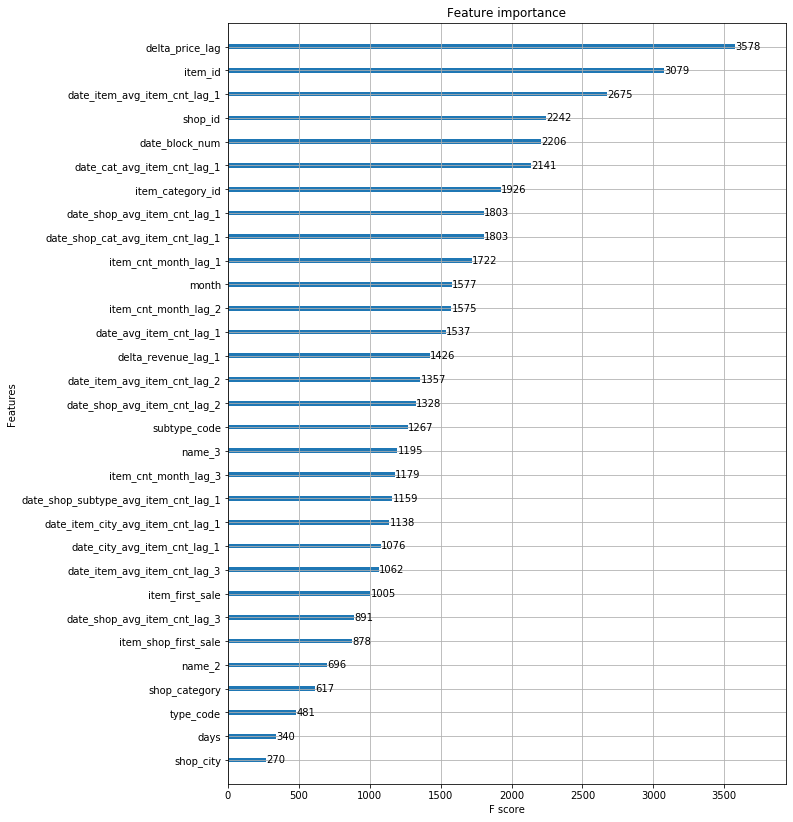

In [74]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

In [63]:
import lightgbm as lgb

lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':-1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0
              }

model = lgb.train(lgb_params, 
                  lgb.Dataset(X_train,label=Y_train), 
                  150, #categorical_feature=cat_features, 
                  valid_sets=lgb.Dataset(X_valid,label=Y_valid), verbose_eval=True,
                 early_stopping_rounds=15)

pred_lgb = model.predict(X_test)

[1]	valid_0's rmse: 1.12593
Training until validation scores don't improve for 15 rounds
[2]	valid_0's rmse: 1.11535
[3]	valid_0's rmse: 1.10549
[4]	valid_0's rmse: 1.09485
[5]	valid_0's rmse: 1.08501
[6]	valid_0's rmse: 1.07547
[7]	valid_0's rmse: 1.06737
[8]	valid_0's rmse: 1.05928
[9]	valid_0's rmse: 1.05158
[10]	valid_0's rmse: 1.04424
[11]	valid_0's rmse: 1.03766
[12]	valid_0's rmse: 1.03171
[13]	valid_0's rmse: 1.0257
[14]	valid_0's rmse: 1.02048
[15]	valid_0's rmse: 1.01433
[16]	valid_0's rmse: 1.00949
[17]	valid_0's rmse: 1.00554
[18]	valid_0's rmse: 1.00067
[19]	valid_0's rmse: 0.996208
[20]	valid_0's rmse: 0.992247
[21]	valid_0's rmse: 0.988154
[22]	valid_0's rmse: 0.98501
[23]	valid_0's rmse: 0.981746
[24]	valid_0's rmse: 0.978238
[25]	valid_0's rmse: 0.975719
[26]	valid_0's rmse: 0.972116
[27]	valid_0's rmse: 0.969811
[28]	valid_0's rmse: 0.967039
[29]	valid_0's rmse: 0.965052
[30]	valid_0's rmse: 0.963174
[31]	valid_0's rmse: 0.961329
[32]	valid_0's rmse: 0.959321
[33]	val

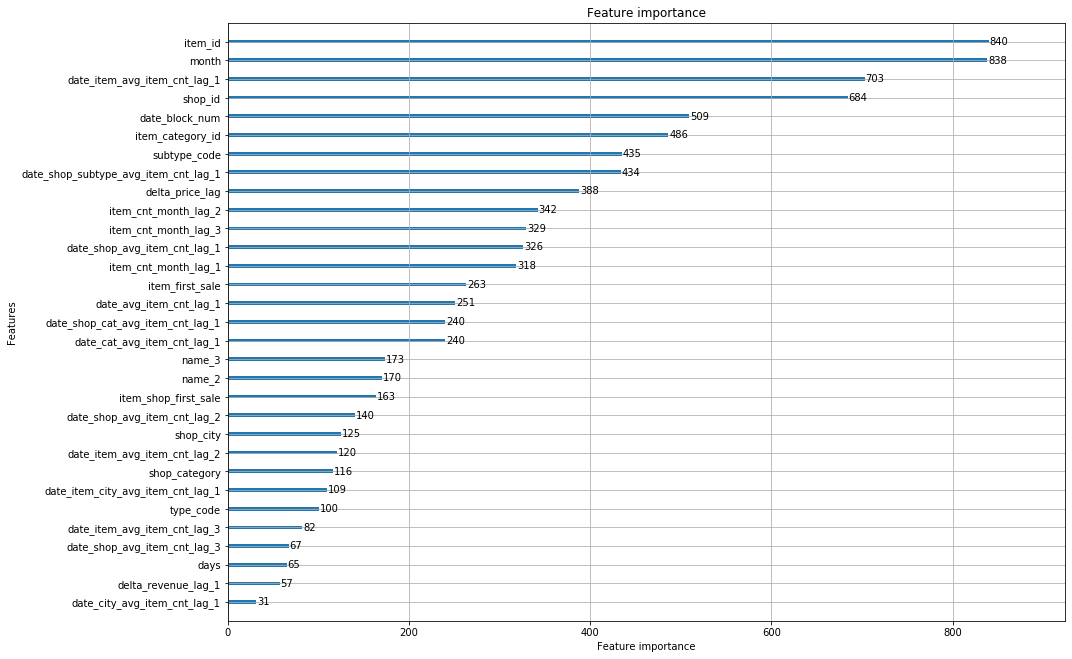

In [64]:
lgb.plot_importance(model, figsize=(15,11))

In [70]:
import utils
sales_util = utils.SalesUtils('../submissions')
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": pred_lgb.clip(0,20)
})
sales_util.save_submission('val_xgb_but_lgb_1',submission)

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Submission file saved as ../submissions\sub_val_xgb_but_lgb_1_2020-07-26.csv
